In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Fdisk Gadget

In [8]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import time_conversion as tiempo
import density
import rotation_mio as rot

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'
##hasta 50

snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
#     print aexp[isnap]

#     lala

    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
        ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
        zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h
        
        r200 = r200*aexp[isnap]/h
        
#         print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        Mgal_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
    

    #------------------ calculamos M90------------------------------------------
        razon  = Mgal_str/M_gal
        cincuenta,    = np.where(razon < 0.50)

        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]

        #componentes de la velocidad del centro de masa
        veloc, = np.where(rstr < r50)

        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        #-------------------------------------------------------------------------------------
        #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr*1e10,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        rn = np.sqrt(xn**2 + yn**2 + zn**2 )

        limit, = np.where(rn < rgal )

        R = np.sqrt(xn[limit]**2+yn[limit]**2)

        nbin = 25
        den, Rbin = density.surf_density(R,mstr[limit]*1e10,nbin)
        
        
        cut, = np.where(Rbin > 3*aexp[isnap])
        pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

        Rd = -1./pol[0]

        Md = 2*np.pi*np.exp(pol[1])*Rd**2

    #--------------------------------------------         
        rtot = np.concatenate([rstr, rgas, rdrk])
        mtot = np.concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])
        
#-------------------------------------------------------------- 
        Mtot_50 = Mc_tot[np.where(rtot_sort < r50)][-1]

        Vr50 = np.sqrt((G*Mtot_50*1e10)/r50)
        
        fdisk = Vr50 / np.sqrt((G*M_gal*1e10)/r50)
                            

        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
    
        Vmax = np.max(Vtot)
        
        fdisk0 = Vmax / np.sqrt((G*M_gal*1e10)/r50)
        fdisk1 = Vmax / np.sqrt((G*Md)/Rd)

        print fdisk1
#         print Vmax
#         print fdisk
        
#--------------------------------------------------------------------------------------------------------------------

#         archivo1 =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_fdisk_time.dat','a')
#         archivo1.write(str('%12.6f'% time) +'\t'+
#                        str('%12.6f'% fdisk) +'\t'+
#                        str('%12.6f'% r50) +'\t'+
#                        str('%12.6f'% (M_gal*1e10)) +'\t'+
#                        str('%12.6f'% (M50*1e10)) +'\t'+
#                        str('%12.6f'% (Mgas_50*1e10)) +'\t'+
#                        str('%12.6f'% (Mdrk_50*1e10)) +'\t'+
#                        str('%12.6f'% Vr50) +'\n')
#         archivo1.close()   
        
#         archivo =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'+str('%s'%vector2[i])+'_fdisk_time_GD2.dat','a')
#         archivo.write(str('%12.6f'% time) +'\t'+
#                       str('%12.6f'% fdisk) +'\t'+
#                       str('%12.6f'% fdisk0) +'\t'+
#                       str('%12.6f'% fdisk1) +'\n')
                    
#         archivo.close()

2.034164120702208
1.6193295820901645
1.452406480762207


## Fdisk Gasoline

In [35]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np


G = 4.299e-6
a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

#path = 'home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'][()]
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'][()]
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'][()]
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'][()]
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'][()]

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'][()]
        mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'][()]
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'][()]

        pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'][()]
        mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'][()]

        pdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Coordinates'][()]
        mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'][()]


    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0]) #*aexp
        ystr = (pstr[:,1]-cm[1])
        zstr = (pstr[:,2]-cm[2])
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

        xgas = (pgas[:,0]-cm[0])
        ygas = (pgas[:,1]-cm[1])
        zgas = (pgas[:,2]-cm[2])
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        xdrk = (pdrk[:,0]-cm[0])
        ydrk = (pdrk[:,1]-cm[1])
        zdrk = (pdrk[:,2]-cm[2])
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0]
        v_y = vel[:,1]
        v_z = vel[:,2]

    #----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(rstr<rgal)
        r_sort = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])

        Mgal_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
        
        
        Rstr   = np.sqrt(xstr**2 + ystr**2)
        limit0 = np.where((Rstr < rgal) & (zstr<3*aexp) & (zstr>-3*aexp))
        rsort0 = np.sort(Rstr[limit0])
        rind0  = np.argsort(Rstr[limit0])
        
        Rgas   = np.sqrt(xgas**2 + ygas**2)
        limit1 = np.where((Rgas < rgal) & (zgas<3*aexp) & (zgas>-3*aexp))
        rsort1 = np.sort(Rgas[limit1])
        rind1  = np.argsort(Rgas[limit1])
        
        Mdisk_s = np.cumsum(mstr[limit0][rind0])[-1] #solo estrellas
        Mdisk_g = np.cumsum(mgas[limit1][rind1])[-1] 
        Mdisk_sum = Mdisk_s + Mdisk_g  #estrella y gas
    
    #------------------ calculamos M90------------------------------------------
        razon = Mgal_str/M_gal
        cincuenta,    = np.where(razon < 0.50)
     
        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]
        
    
#--------------------------------------------------------------       
        rtot= np.concatenate([rstr, rgas, rdrk])
        mtot= np.concatenate([mstr, mgas, mdrk])

        limit_tot = np.where(rtot<r200)
        rtot_sort = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])

        Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])
        
#-------------------------------------------------------------- 
        Mtot_50 = Mc_tot[np.where(rtot_sort < r50)][-1]

        Vr50 = np.sqrt((G*Mtot_50)/r50)
        
        fdisk = Vr50 / np.sqrt((G*M_gal)/r50)
                            

        Vtot = np.sqrt((G*Mc_tot[1:])/rtot_sort[1:])
    
        Vmax = np.max(Vtot)
        
        fdisk0 = Vmax / np.sqrt((G*M_gal)/r50)
        fdisk1 = Vmax / np.sqrt((G*M_gal)/(2*r50))
        fdisk2 = Vmax / np.sqrt((G*Mdisk_s)/(2*r50))
        fdisk3 = Vmax / np.sqrt((G*Mdisk_sum)/(2*r50))
        
#         print Vmax
        
#         print fdisk, time
        
#--------------------------------------------------------------------------------------------------------------------

#         archivo1 =  open('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_fdisk_time.dat','a')
#         archivo1.write(str('%12.6f'% time) +'\t'+
#                        str('%12.6f'% fdisk) +'\t'+
#                        str('%12.6f'% r50) +'\t'+
#                        str('%12.6f'% M_gal) +'\t'+
#                        str('%12.6f'% M50) +'\t'+
#                        str('%12.6f'% Mgas_50) +'\t'+
#                        str('%12.6f'% Mdrk_50) +'\t'+
#                        str('%12.6f'% Vr50) +'\n')
#         archivo1.close()
        
        
        archivo =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'+str('%s'%vector2[i])+'_fdisk_time_GS.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                      str('%12.6f'% fdisk) +'\t'+
                      str('%12.6f'% fdisk0) +'\t'+
                      str('%12.6f'% fdisk1) +'\t'+
                      str('%12.6f'% fdisk2) +'\t'+
                      str('%12.6f'% fdisk3) +'\n')
        archivo.close()

In [5]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/correcciones/M31_fdisk_time_GD2.dat')
time_M31gd   = M31_gd[:,0]
fdisk_M31gd  = M31_gd[:,1]
fdisk0_M31gd = M31_gd[:,2]
fdisk1_M31gd = M31_gd[:,3]
# fdisk2_M31gd = M31_gd[:,4]
# fdisk3_M31gd = M31_gd[:,5]


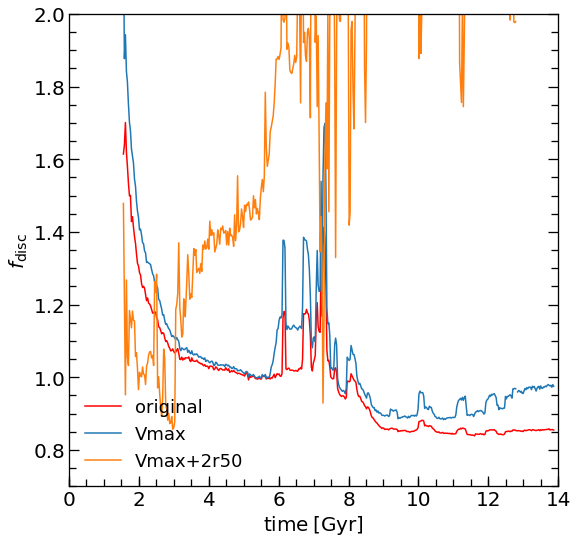

In [6]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M31gd, fdisk_M31gd, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_M31gd, fdisk0_M31gd,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_M31gd, fdisk1_M31gd,'-', lw=1.5, color = 'tab:orange',label='Vmax+2r50')
# ax.plot(time_M31gd, fdisk2_M31gd,'-', lw=1.5, color = 'tab:green',label='Vmax+2r50+Mdisk_star')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=3)


In [10]:
path = '/home/omarioni/'
MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/correcciones/MW_fdisk_time_GD2.dat')
time_MWgd   = MW_gd[:,0]
fdisk_MWgd  = MW_gd[:,1]
fdisk0_MWgd = MW_gd[:,2]
fdisk1_MWgd = MW_gd[:,3]
# fdisk2_MWgd = MW_gd[:,4]
# fdisk3_MWgd = MW_gd[:,5]


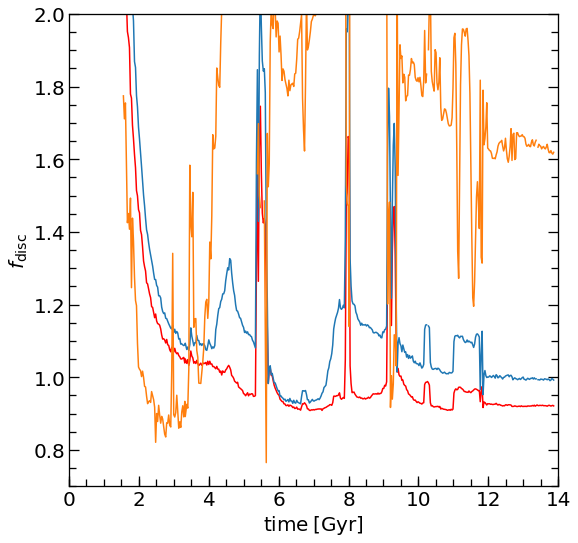

In [11]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_MWgd, fdisk_MWgd, '-', lw=1.5, color = 'r')
ax.plot(time_MWgd, fdisk0_MWgd,'-', lw=1.5, color = 'tab:blue')
ax.plot(time_MWgd, fdisk1_MWgd,'-', lw=1.5, color = 'tab:orange')
# ax.plot(time_MWgd, fdisk2_MWgd,'-', lw=1.5, color = 'tab:green')
# ax.plot(time_MWgd, fdisk3_MWgd,'-', lw=1.5, color = 'tab:purple')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=(0.19,0.63))


In [12]:
path = '/home/omarioni/'
M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/correcciones/M33_fdisk_time_GD2.dat')
time_M33gd   = M33_gd[:,0]
fdisk_M33gd  = M33_gd[:,1]
fdisk0_M33gd = M33_gd[:,2]
fdisk1_M33gd = M33_gd[:,3]
# fdisk2_M33gd = M33_gd[:,4]
# fdisk3_M33gd = M33_gd[:,5]


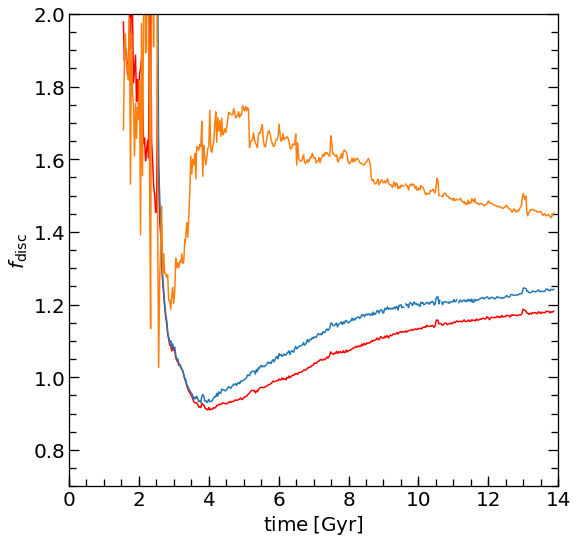

In [13]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M33gd, fdisk_M33gd, '-', lw=1.5, color = 'r')
ax.plot(time_M33gd, fdisk0_M33gd,'-', lw=1.5, color = 'tab:blue')
ax.plot(time_M33gd, fdisk1_M33gd,'-', lw=1.5, color = 'tab:orange')
# ax.plot(time_M33gd, fdisk2_M33gd,'-', lw=1.5, color = 'tab:green')
# ax.plot(time_M33gd, fdisk3_M33gd,'-', lw=1.5, color = 'tab:purple')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=(0.19,0.63))


In [36]:
path = '/home/omarioni/'
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/correcciones/M31_fdisk_time_GS.dat')
time_M31gs   = M31_gs[:,0]
fdisk_M31gs  = M31_gs[:,1]
fdisk0_M31gs = M31_gs[:,2]
fdisk1_M31gs = M31_gs[:,3]
fdisk2_M31gs = M31_gs[:,4]
fdisk3_M31gs = M31_gs[:,5]


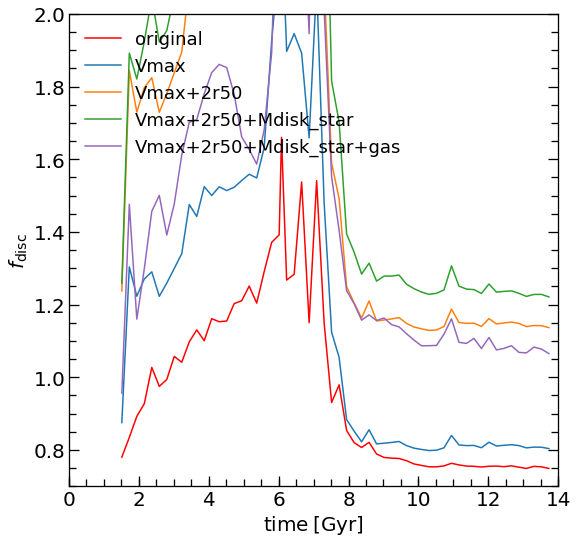

In [37]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M31gs, fdisk_M31gs, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_M31gs, fdisk0_M31gs,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_M31gs, fdisk1_M31gs,'-', lw=1.5, color = 'tab:orange',label='Vmax+2r50')
ax.plot(time_M31gs, fdisk2_M31gs,'-', lw=1.5, color = 'tab:green',label='Vmax+2r50+Mdisk_star')
ax.plot(time_M31gs, fdisk3_M31gs,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)


In [38]:
path = '/home/omarioni/'
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/correcciones/MW_fdisk_time_GS.dat')
time_MWgs   = MW_gs[:,0]
fdisk_MWgs  = MW_gs[:,1]
fdisk0_MWgs = MW_gs[:,2]
fdisk1_MWgs = MW_gs[:,3]
fdisk2_MWgs = MW_gs[:,4]
fdisk3_MWgs = MW_gs[:,5]


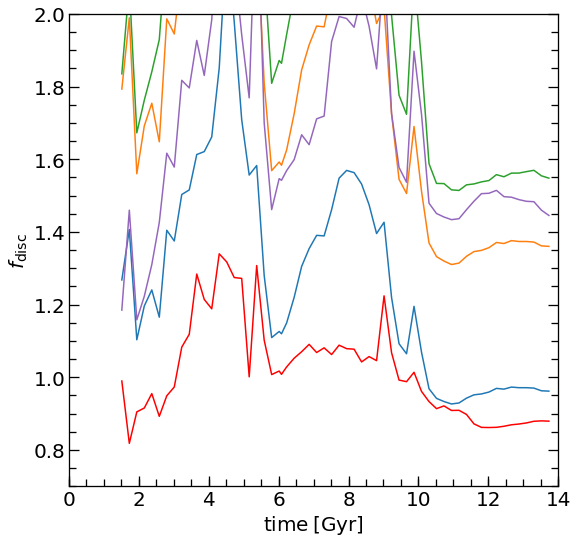

In [39]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_MWgs, fdisk_MWgs, '-', lw=1.5, color = 'r')
ax.plot(time_MWgs, fdisk0_MWgs,'-', lw=1.5, color = 'tab:blue')
ax.plot(time_MWgs, fdisk1_MWgs,'-', lw=1.5, color = 'tab:orange')
ax.plot(time_MWgs, fdisk2_MWgs,'-', lw=1.5, color = 'tab:green')
ax.plot(time_MWgs, fdisk3_MWgs,'-', lw=1.5, color = 'tab:purple')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=(0.19,0.63))


In [40]:
path = '/home/omarioni/'
M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/correcciones/M33_fdisk_time_GS.dat')
time_M33gs   = M33_gs[:,0]
fdisk_M33gs  = M33_gs[:,1]
fdisk0_M33gs = M33_gs[:,2]
fdisk1_M33gs = M33_gs[:,3]
fdisk2_M33gs = M33_gs[:,4]
fdisk3_M33gs = M33_gs[:,5]


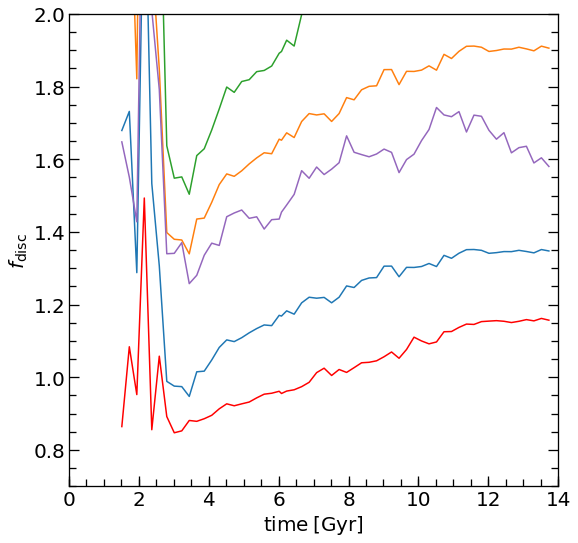

In [41]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M33gs, fdisk_M33gs, '-', lw=1.5, color = 'r')
ax.plot(time_M33gs, fdisk0_M33gs,'-', lw=1.5, color = 'tab:blue')
ax.plot(time_M33gs, fdisk1_M33gs,'-', lw=1.5, color = 'tab:orange')
ax.plot(time_M33gs, fdisk2_M33gs,'-', lw=1.5, color = 'tab:green')
ax.plot(time_M33gs, fdisk3_M33gs,'-', lw=1.5, color = 'tab:purple')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=(0.19,0.63))
